In [ ]:
import numpy as np
import pandas as pd
from IPython.display import clear_output
import json
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch

for dirname, _, filenames in os.walk('C://Users//Иван//Downloads//data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
clear_output()

In [1]:
print(

SyntaxError: incomplete input (149104261.py, line 1)

In [120]:
data = {"categories" : [], "images" : [], "id" : []}

index = 0
for dirname, _, filenames in os.walk('C://Users//Иван//Downloads//archive//dataset//diabetic_retinopathy'):
    for filename in filenames:
        data["id"].append(index)
        data["images"].append(filename)
        data["categories"].append(1)
        index += 1

for dirname, _, filenames in os.walk('C://Users//Иван//Downloads//archive//dataset//normal'):
    for filename in filenames:
        data["id"].append(index)
        data["images"].append(filename)
        data["categories"].append(0)
        index += 1

df = pd.DataFrame(data)

In [121]:
df.head()

,categories,images,id
0,1,10003_left.jpeg,0
1,1,10003_right.jpeg,1
2,1,10007_left.jpeg,2
3,1,10007_right.jpeg,3
4,1,10009_left.jpeg,4


In [136]:
import random
import shutil

filenames = df["images"]
train_set = []
length = len(filenames)

i = 0
current_length = len(train_set)
while current_length < 1800:
    if i == length:
        i = i % length

    if random.randint(0, 10) <= 3 and i not in train_set:
        train_set.append(i)
        current_length += 1

    i += 1

while current_length > 1500:
    if i >= current_length:
        i = i % current_length

    if random.randint(0, 10) <= 3:
        train_set.pop(i)
        current_length -= 1
        
    i += 1

test_set = [i for i in range(0, 2072) if i not in train_set]

df_test = df.copy(deep=True)
df_test = df_test.drop(train_set, axis = 0)

df_train = df.copy(deep=True)
df_train = df_train.drop(test_set, axis = 0)

def move_from_common_to_dir(data, dir):
    os.mkdir(dir)

    filenames = data["images"].values
    
    for i in range(data.shape[0]):
        shutil.copy2('data/' + filenames[i], dir + '/' + filenames[i])

In [137]:
df_test

,categories,images,id
4,1,10009_left.jpeg,4
10,1,10013_left.jpeg,10
14,1,10015_left.jpeg,14
16,1,10017_left.jpeg,16
22,1,10030_left.jpeg,22
...,...,...,...
2156,0,3485_left.jpg,2156
2158,0,4637_left.jpg,2158
2164,0,84_left.jpg,2164
2170,0,951_left.jpg,2170


In [138]:
df_train

,categories,images,id
0,1,10003_left.jpeg,0
1,1,10003_right.jpeg,1
2,1,10007_left.jpeg,2
3,1,10007_right.jpeg,3
5,1,10009_right.jpeg,5
...,...,...,...
2167,0,8_right.jpg,2167
2168,0,939_left.jpg,2168
2169,0,939_right.jpg,2169
2170,0,951_left.jpg,2170


In [139]:
move_from_common_to_dir(df_test, 'test_samples')
move_from_common_to_dir(df_train, 'train_samples')

In [140]:
df_test.to_csv('test.csv')
df_train.to_csv('train.csv')

In [86]:
print(

SyntaxError: incomplete input (149104261.py, line 1)

In [141]:
df_test = pd.read_csv('test.csv')
df_test.drop("Unnamed: 0", axis = 1)
df_train = pd.read_csv('train.csv')
df_train.drop("Unnamed: 0", axis = 1)

y_test = df_test["categories"]
y_train = df_train["categories"]
X_test = df_test.drop("categories", axis = 1)
X_train = df_train.drop("categories", axis = 1)

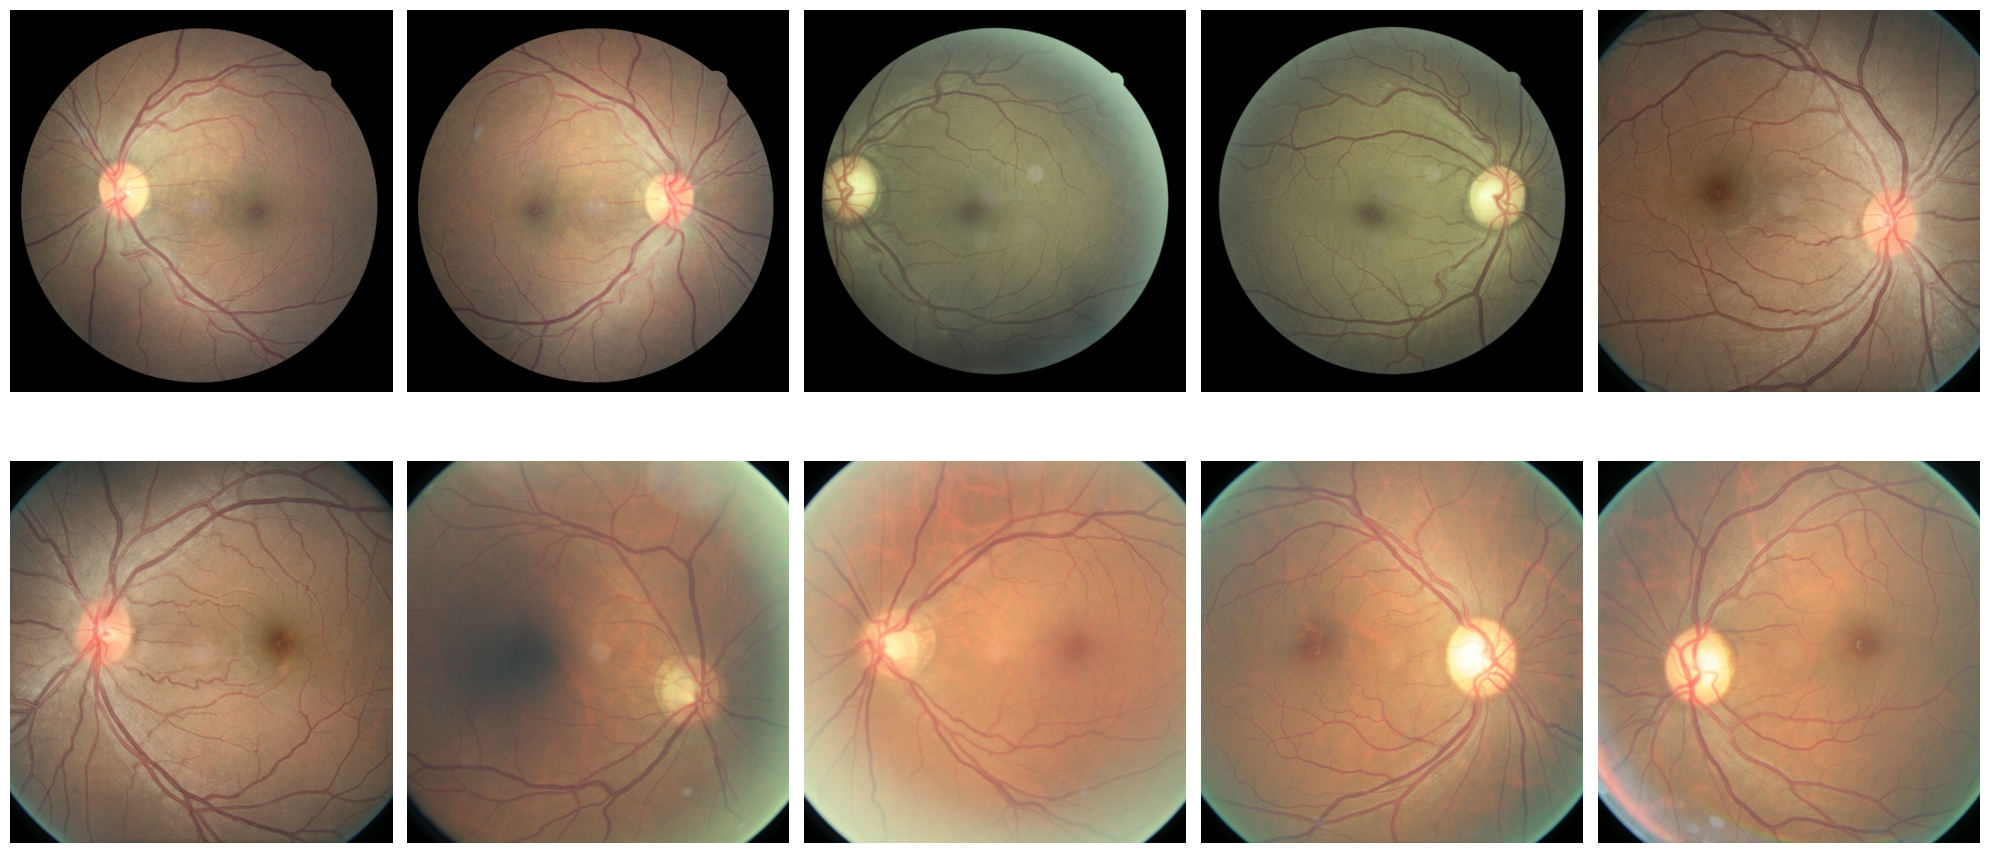

In [ ]:
image_folder = "C://Users//Иван//Downloads//data"

image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]

plt.figure(figsize=(20, 10))
for i, file_name in enumerate(image_files[:10]):
    img_path = os.path.join(image_folder, file_name)
    img = Image.open(img_path)

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Модель и обучение

In [148]:
labels_df = pd.read_csv('train.csv').drop(["Unnamed: 0"], axis=1)
print(labels_df.head().to_markdown())

|    |   categories | images           |   id |
|---:|-------------:|:-----------------|-----:|
|  0 |            1 | 10003_left.jpeg  |    0 |
|  1 |            1 | 10003_right.jpeg |    1 |
|  2 |            1 | 10007_left.jpeg  |    2 |
|  3 |            1 | 10007_right.jpeg |    3 |
|  4 |            1 | 10009_right.jpeg |    5 |


In [150]:
labels_df['categories'].value_counts()

categories
1    767
0    765
Name: count, dtype: int64

In [252]:
from torch.utils.data import Dataset

torch.manual_seed(0)

class pytorch_data(Dataset):
    
    def __init__(self,data_dir,transform,data_type="train_samples", csv_name="train.csv", border = 1260):      
    
        cdm_data=os.path.join(data_dir,data_type)
        
        file_names = os.listdir(cdm_data) 
        idx_choose = np.random.choice(np.arange(len(file_names)), 
                                      border,
                                      replace=False).tolist()
        file_names_sample = [file_names[x] for x in idx_choose]
        self.full_filenames = [os.path.join(cdm_data, f) for f in file_names_sample]
        
        labels_data=os.path.join(data_dir,csv_name) 
        labels_df=pd.read_csv(labels_data)
        labels_df.set_index("id", inplace=True)
        self.labels = labels_df['categories'].values
        self.transform = transform
      
    def __len__(self):
        return len(self.full_filenames)
      
    def __getitem__(self, idx):
        image = Image.open(self.full_filenames[idx]) 
        image = self.transform(image)
        return image, self.labels[idx]

In [ ]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((512,512))])

In [254]:
data_dir = ''
train_dataset = pytorch_data(data_dir, data_transformer, "train_samples", "train.csv")

In [255]:
test_dataset = pytorch_data(data_dir, data_transformer, "test_samples", "test.csv", 600)

In [256]:
train_transf = transforms.Compose([

    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45),         
    transforms.ToTensor()])

test_transf = transforms.Compose([
    transforms.ToTensor()])

train_dataset.transform=train_transf
test_dataset.transform=test_transf

In [257]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_dataset,
                      batch_size=32, 
                      shuffle=True)

val_dl = DataLoader(test_dataset,
                    batch_size=32,
                    shuffle=False)

In [268]:
def findConv2dOutShape(hin,win,conv,pool=2):
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation

    hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

    if pool:
        hout/=pool
        wout/=pool
    return int(hout),int(wout)

import torch.nn as nn
import torch.nn.functional as F

class Network(nn.Module):
    
    def __init__(self, params):
        
        super(Network, self).__init__()
    
        Cin,Hin,Win=params["shape_in"]
        init_f=params["initial_filters"] 
        num_fc1=params["num_fc1"]  
        num_classes=params["num_classes"] 
        self.dropout_rate=params["dropout_rate"] 
        
        self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
        h,w=findConv2dOutShape(Hin,Win,self.conv1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)

    def forward(self,X):
        
        X = F.relu(self.conv1(X)); 
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv4(X))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, self.num_flatten)
        
        X = F.relu(self.fc1(X))
        X=F.dropout(X, self.dropout_rate)
        X = self.fc2(X)
        return F.log_softmax(X, dim=1)

In [269]:
params_model={
        "shape_in": (3,512,512), 
        "initial_filters": 8,    
        "num_fc1": 100,
        "dropout_rate": 0.25,
        "num_classes": 2}

cnn_model = Network(params_model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = cnn_model.to(device)

In [270]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import optim

loss_func = nn.NLLLoss(reduction="sum")

opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [271]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),
                         lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
 "check": False, 
}

In [272]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

def loss_batch(loss_func, output, target, opt=None):
    
    loss = loss_func(output, target)
    pred = output.argmax(dim=1, keepdim=True) 
    metric_b=pred.eq(target.view_as(pred)).sum().item()
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,opt=None):
    
    run_loss=0.0 
    t_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb=xb.to(device)
        yb=yb.to(device)
        output=model(xb) 
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        run_loss+=loss_b       

        if metric_b is not None:
            t_metric+=metric_b    
    
    loss=run_loss/float(len_data) 
    metric=t_metric/float(len_data)
    
    return loss, metric

In [273]:
from tqdm.notebook import trange, tqdm
import copy


def train_val(model, params,verbose=False):
    
    epochs=params["epochs"]
    loss_func=params["f_loss"]
    opt=params["optimiser"]
    train_dl=params["train"]
    val_dl=params["val"]
    lr_scheduler=params["lr_change"]
    weight_path=params["weight_path"]
    
    loss_history={"train": [],"val": []}
    metric_history={"train": [],"val": []}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss=float('inf')
    
    ''' Train Model n_epochs '''
    
    for epoch in tqdm(range(epochs)):
        
        ''' Get the Learning Rate '''
        current_lr=get_lr(opt)
        if(verbose):
            print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))
        
        '''
        
        Train Model
        
        '''
        
        model.train()
        train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        '''
        
        Evaluate Model
        
        '''
        
        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model,loss_func,val_dl)
        
        if(val_loss < best_loss):
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            torch.save(model.state_dict(), weight_path)
            if(verbose):
                print("Copied best model weights!")
        
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            if(verbose):
                print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        if(verbose):
            print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
            print("-"*10) 

    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [ ]:
params_train={
 "train": train_dl,"val": val_dl,
 "epochs": 50,
 "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
 "lr_change": ReduceLROnPlateau(opt,
                                mode='min',
                                factor=0.5,
                                patience=20,
                                verbose=0),
 "f_loss": nn.NLLLoss(reduction="sum"),
 "weight_path": "weights.pt",
}

cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Convergence History')

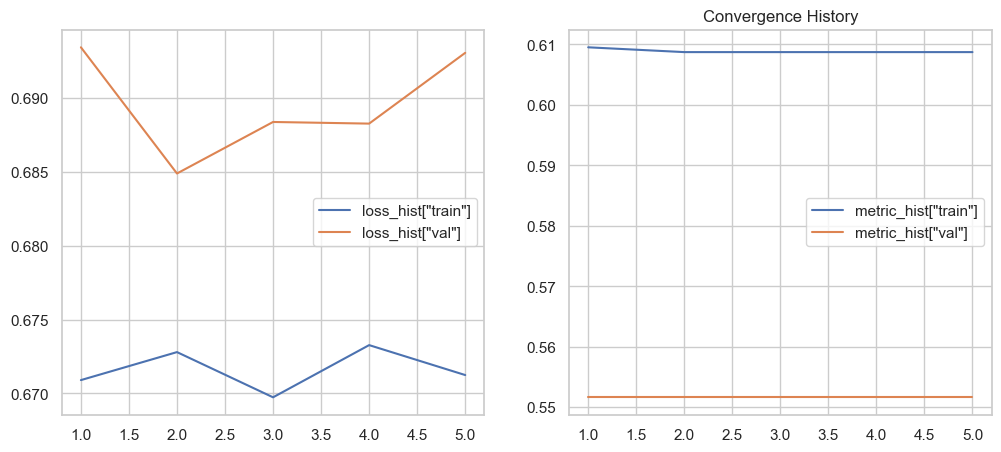

In [277]:
import seaborn as sns; sns.set(style='whitegrid')

epochs=params_train["epochs"]

fig,ax = plt.subplots(1,2,figsize=(12,5))

sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='metric_hist["train"]')
sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='metric_hist["val"]')
plt.title('Convergence History')